In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from __future__ import division

import os

import numpy as np

from glob import glob

import reduce_dblspec 

from astropy.io import fits
from astropy import units as u
from astropy import modeling
from astropy.table import Table

from astropy import modeling
from astropy import constants as cnst

## General Procedure
#### Overscan/Bias
#### Small Scale Flat
#### Combine exposures
#### Sky subtration
#### Extract Target Spectrum & collapse to 1D

How to use this pipeline for Dispersion Solution:

1. define ALL files to be used in reduction (see example for list)
2. set specset = dispersion fcn 
3. use dispersion outputted graphs to estimate wl & pixel matches
4. use guess_plot to get linelist matches to refine pixel estimates 
5. collect ~5 of these in lists
6. use refine_guesses to populate more matches based on inital guesses & plot residuals

In [4]:
def guess_plot(pxguess, wlguess, specset, pxwindw=300, wlwindow=400): 
    fig, (ax1, ax2) = plt.subplots(1,2)

    ds, wlatlas, specatlas, linelist = specset 
    
    #use these graphs to refine matching of arcs to atlas
    
    #first graph 
    plt.axes(ax1)
    ds.plot_spec() #1D spectrum of dispersion solution or is this the arc..waiting on eriks answer
    plt.axvline(pxguess, color='k', ls=':') #plot a vertical line where think peak pixel is in emission lines
    plt.xlim(pxguess-pxwindw/2, pxguess+pxwindw/2)
    #plt.ylim(0, np.max(ds.spec1d[plt.xlim()[0] : plt.xlim()[1]])*1.05)
    plt.title('DS 1D Spectrum')

    
    #second graph
    plt.axes(ax2)
    plt.plot(wlatlas, specatlas) #plots what atlas spectrum looks like
    plt.title('Atlas 1D Spectrum')
    plt.axvline(wlguess, color='k', ls=':')
    plt.xlim(wlguess-wlwindow/2, wlguess+wlwindow/2)
    
    #defs the min & max wavelength peaks to use to scale in next lines
    minpx = np.argmin(np.abs(wlatlas-(wlguess-wlwindow/2)))
    maxpx = np.argmin(np.abs(wlatlas-(wlguess+wlwindow/2)))
    
  
    
    #sets wavelength scales based on graph size-ish
    plt.ylim(0, specatlas[minpx:maxpx].max()*1.05)
    guess = reduce_dblspec.nearest_in_line_list(wlguess, linelist)
    plt.axvline(guess[0], color='r', ls=':') #for 1st wavelength to linelist match draw red vertical line
    
    return guess #outputs wavelength guesses based on atlas spec known linelists

In [9]:
def dispersion(all_side_files,atlasfiles,arcfiles,linelist):
    #Overscan the flats
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)

    header = atlasfiles[0].header    
    specnoao = atlasfiles[0].data
    wlnoao = header['CRVAL1'] + header['CD1_1']*(np.arange(len(specnoao)) - header['CRPIX1'] + 1) #+1 is for 0-based

    #creating dispersion solution
    ds = reduce_dblspec.DispersionSolution(reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl), (320, 360))
    
        
    #outputs graphs of atlas
    plt.figure(figsize=(20,5))
    plt.plot(wlnoao, specnoao)
    plt.title('Atlas 1D Spectrum-wavelengths')
    plt.xlabel('wavelengths')
    if header['IRAFNAME']=='henear.spec': #redside
        #print('red') #testing & works
        plt.xlim(5000,10000)
    if header['IRAFNAME']=='FeAr.spec': #blueside
        #print('blue') #tested & worked
        plt.xlim(3000,5500)
        plt.ylim(0,5e5) #how to make this more flexible?
    
    
    #outputting arc graph so can guess lines
    plt.figure(figsize=(20,5))
    plt.xlabel('pixels')
    plt.title('Arc Lamp 1D Spectrum-pixels')
    ds.plot_spec()
    if header['IRAFNAME']=='FeAr.spec': #blueside
        plt.xlim([2800,0]) #for arc
    
    specset = (ds, wlnoao, specnoao,linelist)
    return (specset) #returns input for guess_plot along with graphs to make pixel & wl guesses

In [10]:
def goodness_of_matches(arcfiles, guesses):
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    #note above only works if all output headers include 'DomeFlat'
    #outputs = []
    #small scale flat creationg - normalized
    nfl = reduce_dblspec.create_normalized_flat(flats)
    header = atlasfiles[0].header    
    
    arcimg = reduce_dblspec.DoubleSpecImage(arcfiles).overscan_sub_and_trim().flatten(nfl)
    if header['IRAFNAME']=='henear.spec': #redside
        ds = reduce_dblspec.DispersionSolution(arcimg, (320, 360), poly_order=3)
    if header['IRAFNAME']=='FeAr.spec': #blueside
        ds = reduce_dblspec.DispersionSolution(arcimg, (205, 260), poly_order=3)



    
    outputs = []
    for i in guesses:
            list_a = ds.guess_line_loc(i[0], i[1]) #guesses(pixel, wl)
            outputs.append(list_a) #why am i collecting these? where are they used?
    if header['IRAFNAME']=='henear.spec': #redside
        ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=5600)
    if header['IRAFNAME']=='FeAr.spec': #blueside
        #ds.guess_from_line_list(linelist,minpeakratio=10, continuous_fit=True, sigmaclip=True, min_wl=3000)
        ds.guess_from_line_list(linelist,minpeakratio=5, continuous_fit=True, sigmaclip=True, max_wl=5400)




    #1st graph-residuals
    plt.figure(figsize=(20,5))
    residuals = ds.plot_solution(True)  
    #2nd graph-populated matches, px to wl;want linear 
    plt.figure(figsize=(20,5))
    ds.plot_spec_wl()
    
    #might need to take these out but trying to fix blueside--prob can remove
    ##if header['IRAFNAME']=='henear.spec': #redside
      ##  plt.xlim(4000,12000)
    ##if header['IRAFNAME']=='FeAr.spec': #blueside
      ##  plt.xlim(2500,6000)
        #plt.xlim()
    
    return (residuals) #this really doesnt do anything, --debug later

In [26]:
#skyaps=[(lower bound pixel location in (x,y), upper bound pixel location in (x,y))]
#play with vmax & vmin to get better contrast
def sky_subtract(targetID,skyaps,vmax,vmin):
    #need these again -flats/overscan
    flats = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim() for fn in 
          reduce_dblspec.find_all_obj('DomeFlat',all_side_files)[:10]] #DO I WANNA KEEP AS ONLY LAST 10???
    nfl = reduce_dblspec.create_normalized_flat(flats)
    
    #locating all files w/ the target & flat/overscan subt
    specs = [reduce_dblspec.DoubleSpecImage(fn).overscan_sub_and_trim().flatten(nfl) 
          for fn in reduce_dblspec.find_all_obj(targetID,all_side_files)]
    #stacking all that data for specific target-help increase s/n 
    comb = reduce_dblspec.combine_imgs(specs)
    
    #plotting
    plt.figure(figsize=(20,10)) #setting up fig size
    subimg, models = comb.subtract_sky(skyaps, skymodel=modeling.models.Linear1D(1,0))
    transpose = False
    return (subimg.show_image(transpose=transpose,vmax=vmax,vmin=vmin))
    #subimg.show_image(transpose=False,vmax=40,vmin=-10);
    


# EXAMPLE: Red (1.5") -- dispersion solution
### Running data pipeline to generate graphs for wl & pixel  emission line matching

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


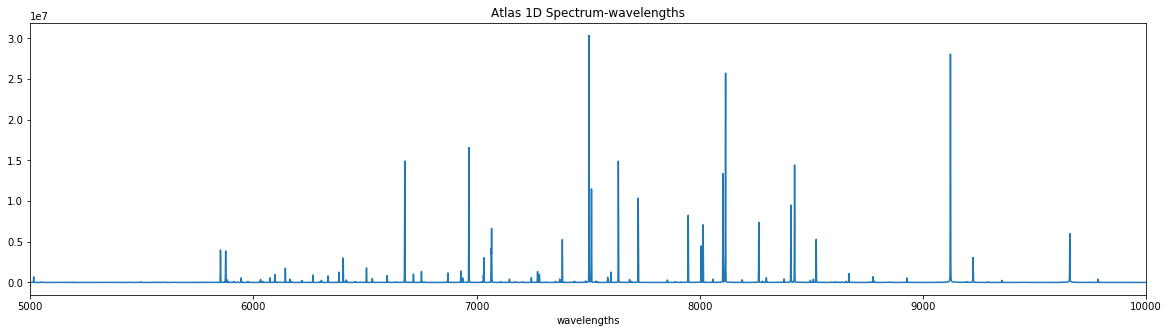

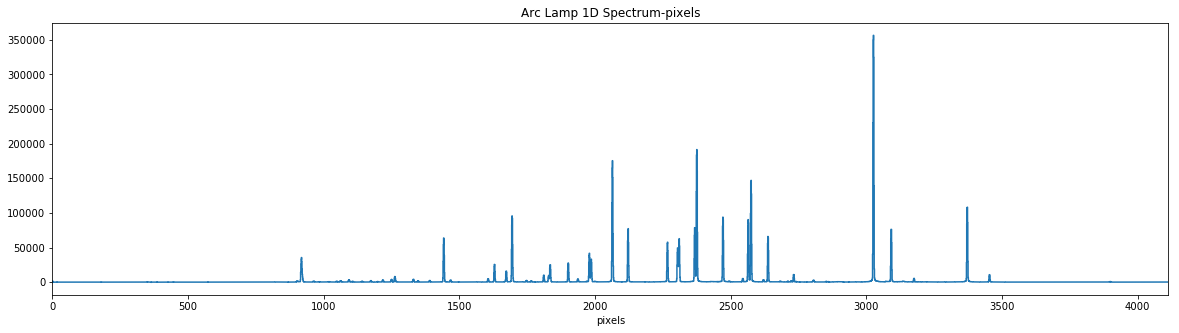

In [12]:
#running data pipeline to generate graphs for wl & pixel matching

#nameing all the datafiles needed
all_side_files = '20170518/red*.fits' #redside
atlasfiles = fits.open('henear.fits') #NOAO atlas #redside
arcfiles = '20170518/red0017.fits' #redside
linelist = reduce_dblspec.HENEAR_LINE_LIST #must be in this form cant use'henearhres.dat'-debug later
#targetfile = '20170518/red0017.fits'#redside

#naming pipeline output for guess_plot use
specset = dispersion(all_side_files, atlasfiles, arcfiles, linelist)

### Collecting guesses from graphs above - manual intervention part

(9122.9673999999995, '9122.9674    ArI')

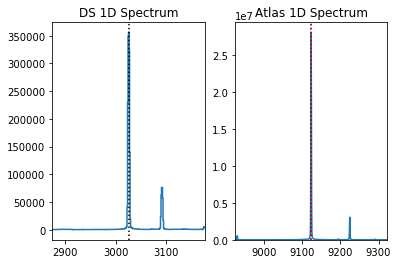

In [13]:
#guessing matching lines from above graphs
#entering (px,wl)guesses & data
guess_plot(3025.5,9122.9674,specset) #outputs (pixel guess, nearest wl/id in linelist)

In [14]:
#collect guesses here ~5 seems good
pixel_guesses = [3372,3027,2375,2065,1630]
atlas_lines = [9657.78,9122.9674,8115.31,7635.1,6965.43]

guesses = list(zip(pixel_guesses, atlas_lines)) #making tuples to pass into fcn later

### Using goodness_of_matches to generate residuals and more line matches based on guesses above

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Skipping line HeI at wl=3187.745 - out of wl min/max
Skipping line ArII at wl=3307.2283 - out of wl min/max
Skipping line ArI at wl=3319.3446 - out of wl min/max
Skipping line ArII at wl=3350.9243 - out of wl min/max
Skipping line HeI at wl=3354.55 - out of wl min/max
Skipping line ArI at wl=3373.4823 - out of wl min/max
Skipping line ArII at wl=3376.4359 - out of wl min/max
Skipping line ArII at wl=3388.5309 - out of wl min/max
Skipping line NeII at wl=3397.866 - out of wl min/max
Skipping line ArI at wl=3406.1804 - out of wl min/max
Skipping line ArII at wl=3414.4583 - out of wl min/max
Skipping line NeI at wl=3417.9035 - out of wl min/max
Skipping line ArII at wl=3421.6107 - out of wl min/max
Skipping line ArII at wl=3454.0952 - out of wl min/max
Skipping line ArII at wl=3464.1272 - out of wl min/max
Skipping line NeI at wl=3472.5711 - out of wl min/max
Skipping line ArII at wl=3476.7474 - out of wl min/max
Skipping line ArII at wl=3480.5055 - out of wl min/max
Skipping line ArII at

Failed to find line KrI at wl=7694.5393: "Guessed line's peak to base ratio is 1.0578827797865025, which is less than 10"
Failed to find line KrI at wl=7854.8215: "Guessed line's peak to base ratio is 0.8644155931496915, which is less than 10"
Failed to find line ArI at wl=7891.075: "Guessed line's peak to base ratio is 0.9941144590061228, which is less than 10"
Failed to find line KrI at wl=7913.4242: "Guessed line's peak to base ratio is 1.0229280821470732, which is less than 10"
Found line ArI at wl=7948.1764
Clipped 0 lines
Failed to find line ArI at wl=8006.1567: "Guessed line's peak to base ratio is 4.148138032795113, which is less than 10"
Failed to find line ArI at wl=8014.7857: "Guessed line's peak to base ratio is 3.3988140467662045, which is less than 10"
Failed to find line KrI at wl=8059.5038: "Guessed line's peak to base ratio is 0.9784268022083137, which is less than 10"
Found line ArI at wl=8103.6931
Clipped 0 lines
Found line ArI at wl=8115.311
Clipped 0 lines
Failed t

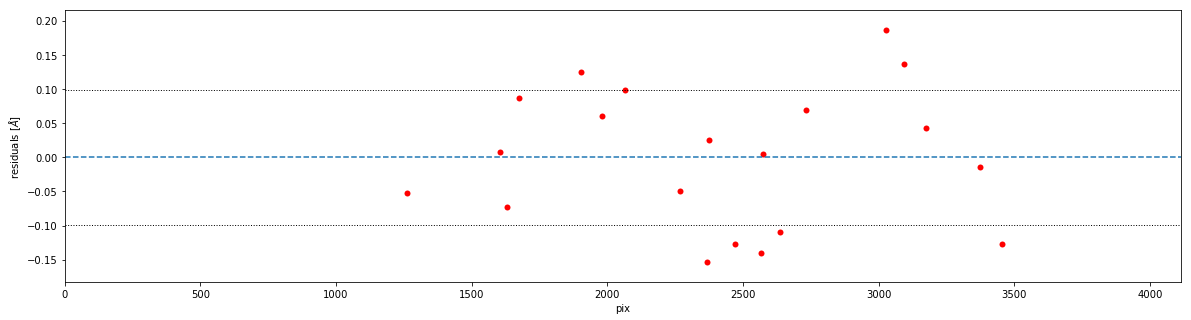

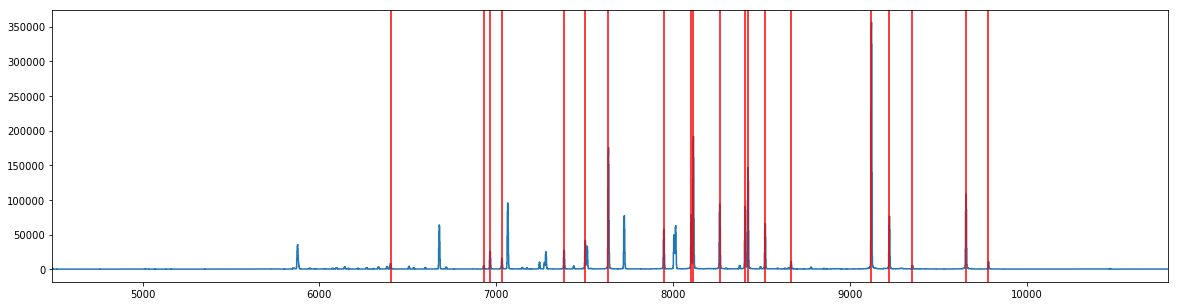

In [15]:
goodness_of_matches(arcfiles,guesses)

# Blue (1.0") --dispersion solution

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


not sure how to get around inverting blue cam side to look similar to atlas 1D spec...
b/c when use guess plot it appear in original orientation (which can be confusing at first)


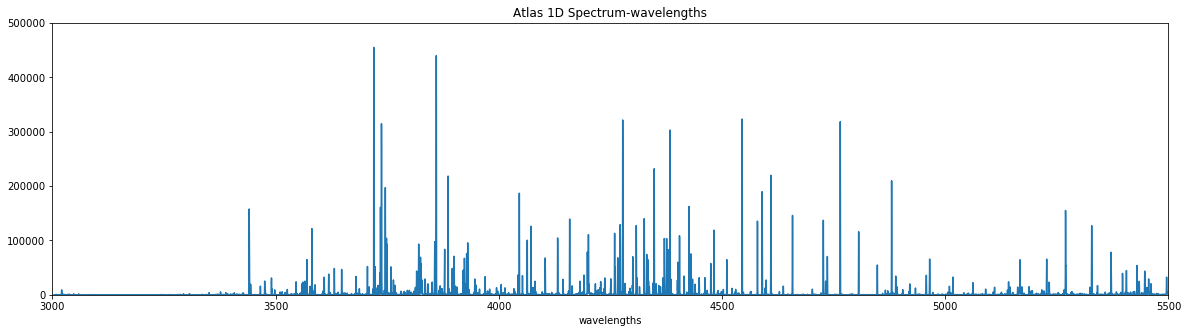

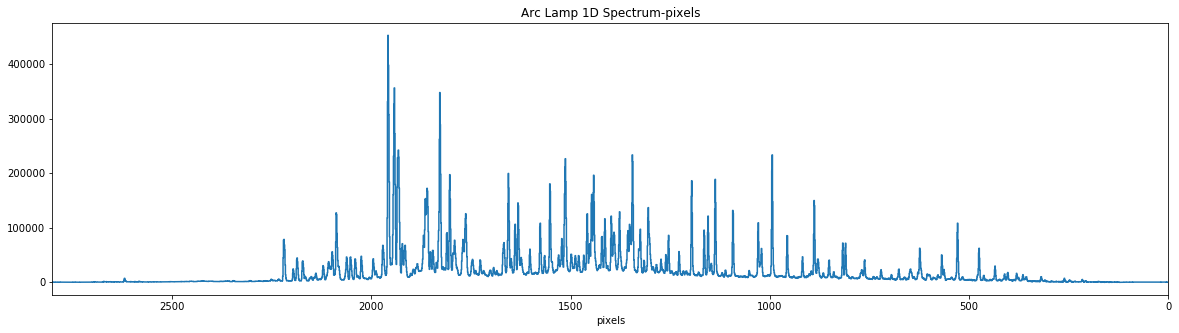

In [16]:
all_side_files = '20170518/blue*.fits' #blueside
atlasfiles = fits.open('fear.fits') #NOAO atlas #blueside
arcfiles = '20170518/blue0011.fits' #blueside
linelist = reduce_dblspec.FEAR_LINE_LIST #must be in this form cant use'fear.dat'--debug later

specset_blue = dispersion(all_side_files, atlasfiles, arcfiles, linelist)


print ('not sure how to get around inverting blue cam side to look similar to atlas 1D spec...''\n'
       'b/c when use guess plot it appear in original orientation (which can be confusing at first)')

(5266.5546000000004, '5266.5546  FeI')

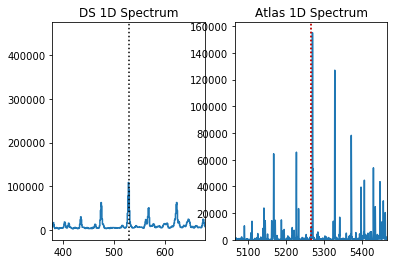

In [17]:
guess_plot(529,5266,specset_blue) #(px,wl)

In [18]:
#collect guesses here
pixel_guesses = [1957,994,1655,1344,529]
atlas_lines = [3719.9346,4764.8646,4044.4179,4383.5445,5266.5546]


guesses = list(zip(pixel_guesses, atlas_lines)) #making tuples to pass into fcn later

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5


Failed to find line FeI at wl=3020.6391: "Guessed line's peak to base ratio is 1.8214690406776914, which is less than 5"
Failed to find line FeI at wl=3024.0325: "Tried to find peak at 2627.8723039364286 but it's in a valley, not a peak"
Failed to find line FeI at wl=3037.3887: "Tried to find peak at 2614.5461689707968 but it's in a valley, not a peak"
Failed to find line FeI at wl=3047.6043: "Guessed line's peak to base ratio is 1.769029573398228, which is less than 5"
Failed to find line FeI at wl=3057.4456: "Guessed line's peak to base ratio is 2.255956064424562, which is less than 5"
Failed to find line FeI at wl=3059.0856: "Guessed line's peak to base ratio is 2.255956064424562, which is less than 5"
Failed to find line FeI at wl=3225.785: "Guessed line's peak to base ratio is 1.2684340170493729, which is less than 5"
Failed to find line ArII at wl=3243.6887: "Guessed line's peak to base ratio is 1.0066716580814996, which is less than 5"
Failed to find line ArII at wl=3350.9243: "

Failed to find line ArII at wl=3979.3559: "Guessed line's peak to base ratio is 1.6280945381500822, which is less than 5"
Failed to find line ArII at wl=3994.7918: "Guessed line's peak to base ratio is 2.2990012002387603, which is less than 5"
Failed to find line FeI at wl=4005.2414: "Guessed line's peak to base ratio is 2.571218523673293, which is less than 5"
Failed to find line ArII at wl=4033.8093: "Guessed line's peak to base ratio is 2.028214879630224, which is less than 5"
Failed to find line ArII at wl=4042.8937: "Tried to find peak at 1658.5004913138616 but it's in a valley, not a peak"
Failed to find line ArI at wl=4044.4179: "Guessed line's peak to base ratio is 4.936185272975721, which is less than 5"
Failed to find line FeI at wl=4045.813: "Guessed line's peak to base ratio is 4.936185272975721, which is less than 5"
Failed to find line ArII at wl=4052.9208: "Guessed line's peak to base ratio is 2.235399486441574, which is less than 5"
Found line FeI at wl=4063.5939
Clippe

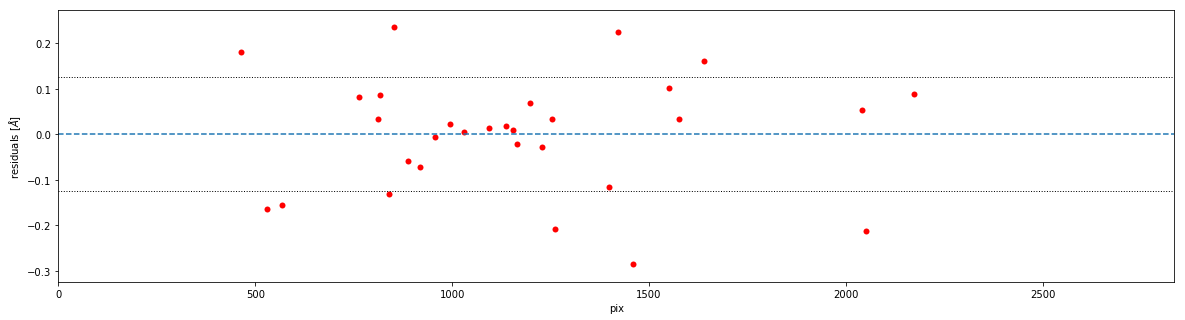

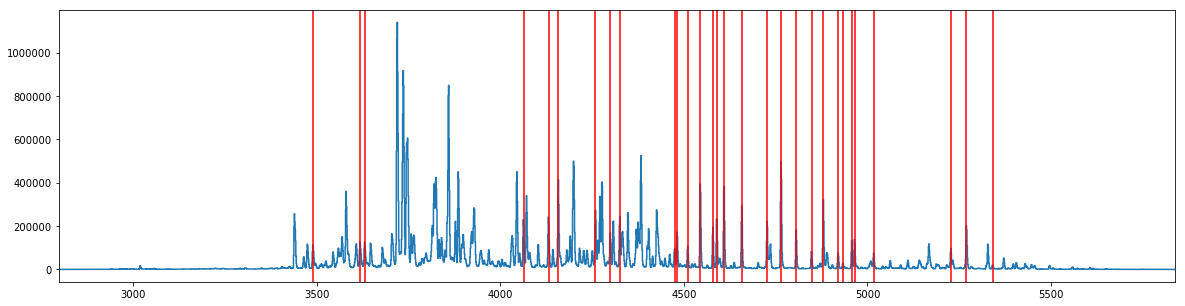

In [19]:
goodness_of_matches(arcfiles,guesses) #yay looks good FINALLY!!
#used some guesses diff from Erik's nb BUT soln looks the same

## Trying a Sky Subtraction on Target

In [ ]:
#naming files needed
targetID = 'Ody_nospec'
skyaps = [(280,310),(380,410)] #sky aperatures-part to subtract sky lines from in spatial direction 
vmax=40
vmin=-10
sky_subtract(targetID,skyaps,vmax,vmin)

/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:88: UserWarning: ROISEC is not one of the values this pipeline assumes.It may not work right where specific values are used (e.g., creating master flats
  warn("ROISEC is not one of the values this pipeline assumes."
/Users/drowland/Desktop/data_pipeline/reduce_dblspec.py:256: RuntimeWarning: invalid value encountered in sqrt
  unc = (result/self.header['GAIN'] + self.unc[tsl]**2)**0.5
